<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/Q9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks
# Samuel Borges Ferreira Gomes
# Prof. Fernando J. Von Zuben
# FEEC/Unicamp - June/2021
## Based on https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

In [4]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("/content/images/%d.png" % epoch) # Please, define the working directory appropriately
        plt.close()

if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=30000, batch_size=32, sample_interval=1000)

Streaming output truncated to the last 5000 lines.
25000 [D loss: 0.622403, acc.: 60.94%] [G loss: 1.114124]
25001 [D loss: 0.582338, acc.: 68.75%] [G loss: 1.107918]
25002 [D loss: 0.675677, acc.: 62.50%] [G loss: 0.985362]
25003 [D loss: 0.622789, acc.: 60.94%] [G loss: 1.006825]
25004 [D loss: 0.664868, acc.: 57.81%] [G loss: 0.963702]
25005 [D loss: 0.594572, acc.: 67.19%] [G loss: 0.972141]
25006 [D loss: 0.692635, acc.: 54.69%] [G loss: 0.988240]
25007 [D loss: 0.642185, acc.: 62.50%] [G loss: 1.027452]
25008 [D loss: 0.607794, acc.: 64.06%] [G loss: 1.067576]
25009 [D loss: 0.566275, acc.: 70.31%] [G loss: 1.102909]
25010 [D loss: 0.636566, acc.: 59.38%] [G loss: 1.012797]
25011 [D loss: 0.600992, acc.: 70.31%] [G loss: 1.015851]
25012 [D loss: 0.667902, acc.: 53.12%] [G loss: 1.022267]
25013 [D loss: 0.655801, acc.: 53.12%] [G loss: 1.055382]
25014 [D loss: 0.567112, acc.: 73.44%] [G loss: 1.020397]
25015 [D loss: 0.620338, acc.: 70.31%] [G loss: 1.066250]
25016 [D loss: 0.6413

#### First image (all noise)

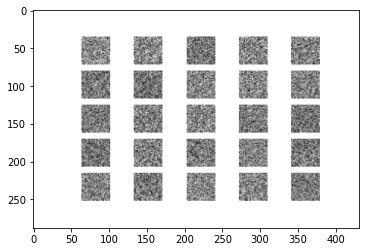

In [6]:
import matplotlib.image as mpimg

image = mpimg.imread("/content/images/0.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()

#### 1000th image 

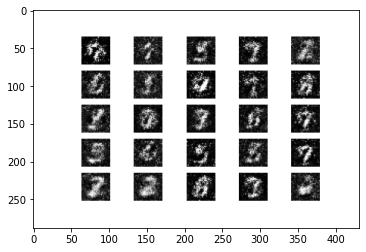

In [7]:
import matplotlib.image as mpimg

image = mpimg.imread("/content/images/1000.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()

#### 10000th image

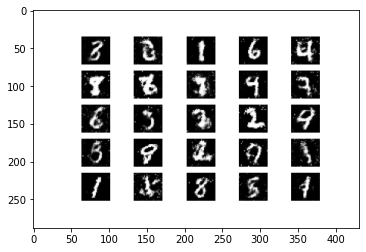

In [17]:
import matplotlib.image as mpimg

image = mpimg.imread("/content/images/10000.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()

#### 2000th image

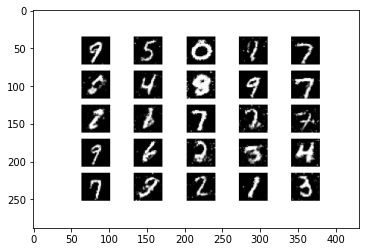

In [9]:
import matplotlib.image as mpimg

image = mpimg.imread("/content/images/20000.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()

#### 2900th image 

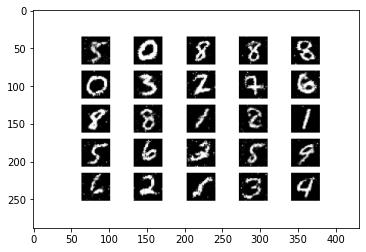

In [10]:
import matplotlib.image as mpimg

image = mpimg.imread("/content/images/29000.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()

#### 3000th (last) image 

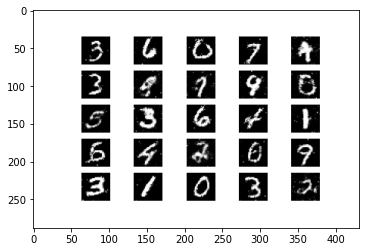

In [27]:
import matplotlib.image as mpimg
img = gan.sample_images(0)
image = mpimg.imread("/content/images/0.png") # Please, define the working directory appropriately
plt.imshow(image)
plt.show()

In [28]:
!zip -r /content/images.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/1000.png (deflated 9%)
  adding: content/images/300050.png (deflated 8%)
  adding: content/images/23000.png (deflated 8%)
  adding: content/images/26000.png (deflated 8%)
  adding: content/images/28000.png (deflated 8%)
  adding: content/images/3000.png (deflated 8%)
  adding: content/images/30000.png (deflated 9%)
  adding: content/images/8000.png (deflated 7%)
  adding: content/images/2000.png (deflated 8%)
  adding: content/images/22000.png (deflated 8%)
  adding: content/images/0.png (deflated 8%)
  adding: content/images/27000.png (deflated 8%)
  adding: content/images/29000.png (deflated 8%)
  adding: content/images/18000.png (deflated 8%)
  adding: content/images/9000.png (deflated 8%)
  adding: content/images/6000.png (deflated 7%)
  adding: content/images/30001.png (deflated 8%)
  adding: content/images/20000.png (deflated 7%)
  adding: content/images/17000.png (deflated 8%)
  adding: content/images/16000.png (defl

#### Animated Progression

I saved the noise progression and posted the gif on [imgur](https://imgur.com/).

The cell below just read the gif.

In [32]:
from IPython.display import Image
Image(url='https://i.imgur.com/cvwzrkY.gif')